# 08_compile_results_for_report

This notebook consolidates key outputs from the full analysis pipeline into a single, report-ready location and generates combined tables for inclusion in the final write-up. **This notebook does not train models or generate new datasets. It performs file management, aggregates previously generated tables, displays saved figures for consolidated inspection, and prints LaTeX code for report inclusion. Some displayed plots/tables are exploratory or intermediate and may not appear in the final report.** The main steps are:

* Defining a set of target result files (CSV tables and PNG plots) produced by earlier notebooks, covering:

  * EDA word-frequency summaries

  * emotion model outputs (both models, all vs negative subsets)

  * BERTopic topic summaries (negative reviews, sadness-only negative reviews, and Falcon-derived topics)

  * LDA topic summaries (negative reviews and sadness-only negative reviews)

  * LLM topic extraction outputs (filtered)

* Searching the project output directories recursively to locate these files and copying them into two dedicated report folders:

  * `output/tables_report/` for tables used in the report

  * `output/plots_report/` for figures used in the report

* Loading copied tables to validate shapes and contents and to support additional compilation steps.

* Creating combined, report-ready tables, including:

  * a wide-format emotion count comparison table across models and subsets (all vs negative), exported as CSV and rendered as LaTeX

  * aligned topic comparison tables across modelling approaches (BERTopic, BERTopic sadness-only, LDA, LDA sadness-only, and BERTopic over Falcon-extracted topics), exported as LaTeX both as a single combined table and as one table per topic
  
* Collecting and renaming selected PNG figures so filenames match report conventions (e.g., standardising Falcon-related figure names), and displaying them for quick visual checking within the notebook.


In [1]:
from pathlib import Path
import sys
import ast
from configparser import ConfigParser

# Resolve project root as the parent of the folder the notebook is currently in
CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD.parent

# Safety fallback
if not (PROJECT_ROOT / "config.ini").exists():
    PROJECT_ROOT = next((p for p in (CWD, *CWD.parents) if (p / "config.ini").exists()), None)
    if PROJECT_ROOT is None:
        raise FileNotFoundError("Could not locate 'config.ini' in the current directory or its parents.")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

CONFIG = ConfigParser()
CONFIG.read(PROJECT_ROOT / "config.ini")

print("CONFIG used:")
for section in CONFIG.sections():
    print(f"\n[{section}]")
    for key, value in CONFIG[section].items():
        print(f"{key} = {value}")


CONFIG used:

[DATA]
data_dir = data
raw_filename = PureGym Customer Reviews.csv
raw_filename_filtered = PureGym Customer Reviews_raw_filtered.csv
preprocessed_filename = PureGym Customer Reviews_preprocessed.csv
preprocessed_filename_sentiment = PureGym Customer Reviews_preprocessed_sentiment.csv
preprocessed_filename_negative = PureGym Customer Reviews_preprocessed_negative.csv
preprocessed_filename_non_negative = PureGym Customer Reviews_preprocessed_non_negative.csv
preprocessed_filename_emotion = PureGym Customer Reviews_preprocessed_emotion.csv
preprocessed_filename_negative_emotion = PureGym Customer Reviews_preprocessed_negative_emotion.csv
preprocessed_filename_non_negative_emotion = PureGym Customer Reviews_preprocessed_non_negative_emotion.csv

[OUTPUT]
plot_dir = output/plots
table_dir = output/tables
model_dir = output/models

[FILTERING]
selected_cols = ["Rating", "Date Experienced", "Review Title", "Review"]
country_code = GB
text_col = Review
detect_language = en
negati

In [2]:
import warnings
import shutil
from IPython.display import Image, display

import re
import numpy as np
import pandas as pd


from utils.data_management.data_io import load_csv

warnings.filterwarnings("ignore", category=DeprecationWarning)


# REPRODUCIBILITY
SEED = CONFIG["REPRODUCIBILITY"].getint("SEED")
np.random.seed(SEED)

# OUTPUT
PLOT_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["PLOT_DIR"] 
TABLE_DIR = PROJECT_ROOT / CONFIG["OUTPUT"]["TABLE_DIR"] 

PLOT_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

print("SEED:", SEED)


SEED: 901


## Report Tables

In [3]:
# Report table filenames
FILES = {
    "BERTOPIC_EMO_NEG_SAD_TOP": "bertopic_emotion_negative_sadness_top_topics.csv",
    "BERTOPIC_EMO_NEG_SAD_INFO": "bertopic_emotion_negative_sadness_topic_info.csv",
    "BERTOPIC_NEG_TOP": "bertopic_negative_top_topics.csv",
    "BERTOPIC_NEG_INFO": "bertopic_negative_topic_info.csv",
    "EMO_ALL_BSAVANI": "emotion_counts_all_reviews_bhadresh_savani_bert_base_uncased_emotion.csv",
    "EMO_ALL_JHART": "emotion_counts_all_reviews_j_hartmann_emotion_english_distilroberta_base.csv",
    "EMO_NEG_BSAVANI": "emotion_counts_negative_reviews_bhadresh_savani_bert_base_uncased_emotion.csv",
    "EMO_NEG_JHART": "emotion_counts_negative_reviews_j_hartmann_emotion_english_distilroberta_base.csv",
    "LDA_NEG_EMO_SAD": "lda_preprocessed_negative_emotion_sadness_gensim_lda_topics.csv",
    "LDA_NEG": "lda_preprocessed_negative_gensim_lda_topics.csv",
    "LLM_TOPICS_FILTERED": "llm_topics_negative_unprocessed_filtered.csv",
    "TOP10_NEG": "trustpilot_negative_top10_words.csv",
    "TOP10_ALL": "trustpilot_top10_words.csv",
    "BERTOPIC_LLM_TOP": "bertopic_llm_topics_negative_top_topics.csv",
    "BERTOPIC_LLM_INFO": "bertopic_llm_topics_negative_topic_info.csv",
}

In [4]:
# Collect key output tables into a single folder for reporting
REPORT_TABLES_DIR = PROJECT_ROOT/"output/tables_report"
REPORT_TABLES_DIR.mkdir(parents=True, exist_ok=True)

TARGET_FILENAMES = set(FILES.values())
all_csvs = [p for p in TABLE_DIR.rglob("*.csv") if REPORT_TABLES_DIR not in p.parents]
matches = {p.name: p for p in all_csvs if p.name in TARGET_FILENAMES}

copied = []
for fname in sorted(TARGET_FILENAMES):
    src = matches.get(fname)
    if src is None:
        continue
    dst = REPORT_TABLES_DIR / fname
    shutil.copy2(src, dst)
    copied.append(dst)

missing = sorted(TARGET_FILENAMES - set(matches.keys()))
print("Report tables folder:", REPORT_TABLES_DIR)
print(f"Copied {len(copied)} file(s).")
if missing:
    print("Missing (not found anywhere under TABLE_DIR):")
    for m in missing:
        print("-", m)
else:
    print("All target files were found and copied.")


Report tables folder: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/tables_report
Copied 14 file(s).
Missing (not found anywhere under TABLE_DIR):
- llm_topics_negative_unprocessed_filtered.csv


In [5]:
# Load copied report tables and display heads
report_files = [REPORT_TABLES_DIR / f for f in sorted(TARGET_FILENAMES) if (REPORT_TABLES_DIR / f).exists()]
print(f"Files in tables_report: {len(report_files)}")

for p in report_files:
    df_tmp = pd.read_csv(p)
    print("\nFile:", p.name, "| shape:", df_tmp.shape)
    display(df_tmp)


Files in tables_report: 14

File: bertopic_emotion_negative_sadness_top_topics.csv | shape: (4, 3)


,Topic,Count,TopWords
0,0,152,"membership, cancel, email, customer, service, ..."
1,1,66,"machine, weight, bench, go, press, space, one,..."
2,2,62,"shower, cold, water, temperature, dirty, go, h..."
3,3,55,"class, book, cancel, get, time, attend, staff,..."



File: bertopic_emotion_negative_sadness_topic_info.csv | shape: (7, 5)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,304,-1_machine_time_class_get,"['machine', 'time', 'class', 'get', 'member', ...",['two year go get bad time get well look new g...
1,0,152,0_membership_cancel_email_customer,"['membership', 'cancel', 'email', 'customer', ...",['hello join bedford nearly three month ago fi...
2,1,66,1_machine_weight_bench_go,"['machine', 'weight', 'bench', 'go', 'press', ...",['edinburgh craigleith lack far busy weight ma...
3,2,62,2_shower_cold_water_temperature,"['shower', 'cold', 'water', 'temperature', 'di...",['change room facility unpleasant especially c...
4,3,55,3_class_book_cancel_get,"['class', 'book', 'cancel', 'get', 'time', 'at...",['arrived class morning one show take class ca...
5,4,47,4_clean_change_use_machine,"['clean', 'change', 'use', 'machine', 'toilet'...",['recently ask submit feedback follow recent v...
6,5,26,5_air_condition_aircon_heat,"['air', 'condition', 'aircon', 'heat', 'work',...",['great portland st actually cavendish mew unb...



File: bertopic_llm_topics_negative_top_topics.csv | shape: (4, 3)


,Topic,Count,TopWords
0,0,248,"membership, customer, service, fee, bad, issue..."
1,1,85,"shower, water, cold, room, locker, hot, temper..."
2,2,81,"toilet, smell, smelly, room, changing, dirty, ..."
3,3,79,"equipment, space, staff, weight, cardio, machi..."



File: bertopic_llm_topics_negative_topic_info.csv | shape: (10, 5)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,342,-1_machine_equipment_parking_broken,"['machine', 'equipment', 'parking', 'broken', ...","['equipment broken changing room dirty need', ..."
1,0,248,0_membership_customer_service_fee,"['membership', 'customer', 'service', 'fee', '...","['bad customer service', 'bad customer service..."
2,1,85,1_shower_water_cold_room,"['shower', 'water', 'cold', 'room', 'locker', ...","['shower cold staff', 'shower cold', 'shower b..."
3,2,81,2_toilet_smell_smelly_room,"['toilet', 'smell', 'smelly', 'room', 'changin...",['changing room dirty smell bad cleaning poor'...
4,3,79,3_equipment_space_staff_weight,"['equipment', 'space', 'staff', 'weight', 'car...",['space good maintenance bad broken equipment'...
5,4,61,4_staff_member_bad_experience,"['staff', 'member', 'bad', 'experience', 'rude...",['bad experience bad manager unfair treatment'...
6,5,52,5_air_conditioning_problem_aircon,"['air', 'conditioning', 'problem', 'aircon', '...","['air conditioning service', 'air conditioning..."
7,6,52,6_cleaning_hygiene_station_cleanliness,"['cleaning', 'hygiene', 'station', 'cleanlines...","['equipment staff hygiene', 'staff cleanliness..."
8,7,46,7_class_instructor_cancelled_bike,"['class', 'instructor', 'cancelled', 'bike', '...","['class', 'class', 'class']"
9,8,36,8_equipment_rusty_suitable_good,"['equipment', 'rusty', 'suitable', 'good', 'be...","['equipment', 'equipment', 'equipment']"



File: bertopic_negative_top_topics.csv | shape: (4, 3)


,Topic,Count,TopWords
0,0,512,"shower, toilet, room, dirty, cleaning, changin..."
1,1,337,"membership, email, cancel, customer, service, ..."
2,2,223,"machine, weight, bench, one, space, need, card..."
3,3,132,"class, instructor, cancelled, booked, booking,..."



File: bertopic_negative_topic_info.csv | shape: (11, 5)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,717,-1_machine_time_staff_people,"['machine', 'time', 'staff', 'people', 'member...",['hi happy actually time remodelling supposed ...
1,0,512,0_shower_toilet_room_dirty,"['shower', 'toilet', 'room', 'dirty', 'cleanin...",['good locker room shower need better cleaning...
2,1,337,1_membership_email_cancel_customer,"['membership', 'email', 'cancel', 'customer', ...",['great shop floor staff company morally bankr...
3,2,223,2_machine_weight_bench_one,"['machine', 'weight', 'bench', 'one', 'space',...",['going month sadly going downhill know sugges...
4,3,132,3_class_instructor_cancelled_booked,"['class', 'instructor', 'cancelled', 'booked',...",['forgot mobile staff let cycle class notified...
5,4,101,4_member_staff_manager_pt,"['member', 'staff', 'manager', 'pt', 'manageme...",['london wall site morning th aug hr working d...
6,5,99,5_hour_opening_open_closed,"['hour', 'opening', 'open', 'closed', 'pm', 't...",['brag open changed opening hour one used come...
7,6,91,6_air_conditioning_hot_working,"['air', 'conditioning', 'hot', 'working', 'con...",['review air conditioning problem trainer clas...
8,7,65,7_parking_car_park_fine,"['parking', 'car', 'park', 'fine', 'ticket', '...",['unfortunately expensive ever paying parking ...
9,8,48,8_music_loud_class_headphone,"['music', 'loud', 'class', 'headphone', 'volum...",['clean music good thinking go different time ...



File: emotion_counts_all_reviews_bhadresh_savani_bert_base_uncased_emotion.csv | shape: (6, 2)


,Emotion,Count
0,joy,8163
1,anger,1402
2,sadness,1027
3,love,356
4,fear,287
5,surprise,65



File: emotion_counts_all_reviews_j_hartmann_emotion_english_distilroberta_base.csv | shape: (7, 2)


,Emotion,Count
0,joy,4289
1,neutral,3691
2,sadness,1458
3,fear,554
4,surprise,490
5,anger,477
6,disgust,341



File: emotion_counts_negative_reviews_bhadresh_savani_bert_base_uncased_emotion.csv | shape: (6, 2)


,Emotion,Count
0,joy,868
1,anger,720
2,sadness,580
3,fear,121
4,love,61
5,surprise,18



File: emotion_counts_negative_reviews_j_hartmann_emotion_english_distilroberta_base.csv | shape: (7, 2)


,Emotion,Count
0,sadness,712
1,neutral,604
2,anger,271
3,fear,243
4,disgust,205
5,surprise,183
6,joy,150



File: lda_preprocessed_negative_emotion_sadness_gensim_lda_topics.csv | shape: (3, 6)


,Topic,TopicId,Count,TopWords_lambda_1_0,TopWords_lambda_0_1,Coherence_c_v
0,1,1,429,"shower, change, go, time, member","shower, order, clean, bad, leave",0.398338
1,2,3,182,"machine, open, weight, since, space","weight, space, press, free, workout",0.398338
2,3,2,101,"cancel, class, membership, get, pay","cancel, membership, subscription, freeze, say",0.398338



File: lda_preprocessed_negative_gensim_lda_topics.csv | shape: (5, 6)


,Topic,TopicId,Count,TopWords_lambda_1_0,TopWords_lambda_0_1,Coherence_c_v
0,1,1,1150,"time, member, room, people, one","room, changing, toilet, locker, open",0.403075
1,2,2,558,"staff, member, shower, water, like","water, air, hot, access, cold",0.403075
2,3,5,460,"class, hour, time, spin, early","class, spin, early, min, instructor",0.403075
3,4,3,166,"membership, customer, email, service, month","membership, email, cancel, £, cancelled",0.403075
4,5,4,34,"machine, weight, area, space, busy","weight, space, amount, cleaned, machine",0.403075



File: trustpilot_negative_top10_words.csv | shape: (10, 2)


,word,count
0,time,763
1,machine,738
2,member,710
3,staff,608
4,class,608
5,one,603
6,get,541
7,people,535
8,membership,502
9,shower,494



File: trustpilot_top10_words.csv | shape: (10, 2)


,word,count
0,class,3651
1,good,3494
2,staff,3453
3,great,3387
4,friendly,2371
5,clean,2349
6,machine,2249
7,time,2189
8,always,1844
9,would,1622


### Combine Tables

In [6]:
# One combined table with topic sections 
N_TOPICS = 4
LAMBDA_WORDS_COL = "TopWords_lambda_0_1" 

from pathlib import Path

def top5(words: str) -> str:
    if not isinstance(words, str):
        return ""
    return ", ".join([w.strip() for w in words.split(",")[:5]])

def load_top_topics(
    path: Path,
    *,
    topic_min: int,
    n: int,
    words_col: str = "TopWords",
    has_count: bool = True,
) -> pd.DataFrame:
    df = pd.read_csv(path).copy()
    df = df[df["Topic"] >= topic_min].head(n).copy()

    if words_col not in df.columns:
        available = [c for c in df.columns if c.lower().startswith("topwords")]
        raise KeyError(
            f"Column '{words_col}' not found in {path.name}. "
            f"Available TopWords-like columns: {available}"
        )

    df["TopWords"] = df[words_col].apply(top5)

    if has_count and "Count" in df.columns:
        df["Count"] = pd.to_numeric(df["Count"], errors="coerce").round(0).astype("Int64")
    else:
        df["Count"] = pd.Series([pd.NA] * len(df), dtype="Int64")

    return df[["Topic", "Count", "TopWords"]]

def method_frame(df: pd.DataFrame, method: str) -> pd.DataFrame:
    out = df.copy()
    out["Method"] = method
    return out

# Load tables
df_bt = load_top_topics(
    REPORT_TABLES_DIR / FILES["BERTOPIC_NEG_TOP"],
    topic_min=0,
    n=N_TOPICS,
    words_col="TopWords",
    has_count=True,
)

df_bt_sad = load_top_topics(
    REPORT_TABLES_DIR / FILES["BERTOPIC_EMO_NEG_SAD_TOP"],
    topic_min=0,
    n=N_TOPICS,
    words_col="TopWords",
    has_count=True,
)

# LDA now WITH counts, and using TopWords_lambda_0_1 only
df_lda = load_top_topics(
    REPORT_TABLES_DIR / FILES["LDA_NEG"],
    topic_min=1,
    n=N_TOPICS,
    words_col=LAMBDA_WORDS_COL,
    has_count=True,
)

df_lda_sad = load_top_topics(
    REPORT_TABLES_DIR / FILES["LDA_NEG_EMO_SAD"],
    topic_min=1,
    n=N_TOPICS,
    words_col=LAMBDA_WORDS_COL,
    has_count=True,
)

df_bt_falcon = load_top_topics(
    REPORT_TABLES_DIR / FILES["BERTOPIC_LLM_TOP"],
    topic_min=0,
    n=N_TOPICS,
    words_col="TopWords",
    has_count=True,
)

df_long = pd.concat(
    [
        method_frame(df_bt, "BERTopic"),
        method_frame(df_bt_sad, "BERTopic (Sad only)"),
        method_frame(df_lda, "LDA"),
        method_frame(df_lda_sad, "LDA (Sad only)"),
        method_frame(df_bt_falcon, "BERTopic (Falcon)"),
    ],
    ignore_index=True,
)

# Remap LDA topic numbers for alignment to Topic 0..N-1 (Topic 1→0, 2→1, ...)
mask_lda = df_long["Method"].str.startswith("LDA")
df_long.loc[mask_lda, "Topic"] = df_long.loc[mask_lda, "Topic"] - 1

# Build one display table (keeps a Topic column for the notebook view only)
df_display = (
    df_long[df_long["Topic"].between(0, N_TOPICS - 1)]
    .loc[:, ["Topic", "Method", "Count", "TopWords"]]
    .sort_values(["Topic", "Method"])
    .reset_index(drop=True)
)
display(df_display)

# Build LaTeX with topic section headers and rules
methods_order = ["BERTopic", "BERTopic (Sad only)", "LDA", "LDA (Sad only)", "BERTopic (Falcon)"]


,Topic,Method,Count,TopWords
0,0,BERTopic,512,"shower, toilet, room, dirty, cleaning"
1,0,BERTopic (Falcon),248,"membership, customer, service, fee, bad"
2,0,BERTopic (Sad only),152,"membership, cancel, email, customer, service"
3,0,LDA,1150,"room, changing, toilet, locker, open"
4,0,LDA (Sad only),429,"shower, order, clean, bad, leave"
5,1,BERTopic,337,"membership, email, cancel, customer, service"
6,1,BERTopic (Falcon),85,"shower, water, cold, room, locker"
7,1,BERTopic (Sad only),66,"machine, weight, bench, go, press"
8,1,LDA,558,"water, air, hot, access, cold"
9,1,LDA (Sad only),182,"weight, space, press, free, workout"


In [7]:
# Read coherence once per LDA run (same value repeated in the CSV)
def read_coherence_cv(path: Path) -> float | None:
    df = pd.read_csv(path)
    if "Coherence_c_v" not in df.columns:
        return None
    s = pd.to_numeric(df["Coherence_c_v"], errors="coerce").dropna()
    return float(s.iloc[0]) if not s.empty else None

lda_cv = read_coherence_cv(REPORT_TABLES_DIR / FILES["LDA_NEG"])
lda_sad_cv = read_coherence_cv(REPORT_TABLES_DIR / FILES["LDA_NEG_EMO_SAD"])

def format_method_label(method: str) -> str:
    if method == "LDA":
        if lda_cv is None:
            return r"LDA ($\lambda=0.1$)"
        return rf"LDA ($\lambda=0.1$, $c_v={lda_cv:.3f}$)"
    if method == "LDA (Sad only)":
        if lda_sad_cv is None:
            return r"LDA (Sad only) ($\lambda=0.1$)"
        return rf"LDA (Sad only) ($\lambda=0.1$, $c_v={lda_sad_cv:.3f}$)"
    return method

# Build LaTeX with topic section headers and rules
methods_order = ["BERTopic", "BERTopic (Sad only)", "LDA", "LDA (Sad only)", "BERTopic (Falcon)"]

topic_blocks = []
for t in range(N_TOPICS):
    block = df_long[df_long["Topic"] == t].copy()
    block = block.set_index("Method").reindex(methods_order).reset_index()
    block = block[["Method", "Count", "TopWords"]]
    topic_blocks.append((t, block))

latex_lines = []
latex_lines.append(r"\begin{table}")
latex_lines.append(r"\centering")
latex_lines.append(
    r"\caption{Topic comparisons for negative reviews only across topic modelling approaches. "
    r"For LDA, top words use relevance at $\lambda=0.1$ (as in pyLDAvis), and $c_v$ coherence is reported. "
    r"LDA topics are indexed from Topic 1 onwards (Topic 0 corresponds to no-topic filtering). "
    r"All other methods are indexed from Topic 0. Topic $-1$ corresponds to outliers and is not shown.}"
)
latex_lines.append(r"\label{tab:negative_reviews_topics_combined}")
latex_lines.append(r"\begin{tabular}{lrl}")
latex_lines.append(r"\toprule")
latex_lines.append(r"Method & Count & TopWords \\")
latex_lines.append(r"\midrule")

for i, (t, block) in enumerate(topic_blocks):
    if i > 0:
        latex_lines.append(r"\midrule")
    latex_lines.append(rf"\multicolumn{{3}}{{l}}{{\textbf{{Topic {t}}}}} \\")
    latex_lines.append(r"\midrule")
    for _, row in block.iterrows():
        method = format_method_label(str(row["Method"]))
        count = "" if pd.isna(row["Count"]) else str(int(row["Count"]))
        words = "" if pd.isna(row["TopWords"]) else str(row["TopWords"])

        # Escape LaTeX-breaking chars in text fields (keep math in method label intact)
        words = words.replace("&", r"\&")

        latex_lines.append(f"{method} & {count} & {words} \\\\")

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\end{table}")

latex_str = "\n".join(latex_lines)
print(latex_str)


\begin{table}
\centering
\caption{Topic comparisons for negative reviews only across topic modelling approaches. For LDA, top words use relevance at $\lambda=0.1$ (as in pyLDAvis), and $c_v$ coherence is reported. LDA topics are indexed from Topic 1 onwards (Topic 0 corresponds to no-topic filtering). All other methods are indexed from Topic 0. Topic $-1$ corresponds to outliers and is not shown.}
\label{tab:negative_reviews_topics_combined}
\begin{tabular}{lrl}
\toprule
Method & Count & TopWords \\
\midrule
\multicolumn{3}{l}{\textbf{Topic 0}} \\
\midrule
BERTopic & 512 & shower, toilet, room, dirty, cleaning \\
BERTopic (Sad only) & 152 & membership, cancel, email, customer, service \\
LDA ($\lambda=0.1$, $c_v=0.403$) & 1150 & room, changing, toilet, locker, open \\
LDA (Sad only) ($\lambda=0.1$, $c_v=0.398$) & 429 & shower, order, clean, bad, leave \\
BERTopic (Falcon) & 248 & membership, customer, service, fee, bad \\
\midrule
\multicolumn{3}{l}{\textbf{Topic 1}} \\
\midrule
BERTop

In [8]:
# Top-10 word frequency tables (wide LaTeX) - compatible with older pandas
from pathlib import Path
import pandas as pd

def _load_top10_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path).copy()
    df.columns = [c.strip().lower() for c in df.columns]
    if not {"word", "count"}.issubset(df.columns):
        raise KeyError(f"{path.name} must have columns: word, count")
    df["word"] = df["word"].astype(str)
    df["count"] = pd.to_numeric(df["count"], errors="coerce")
    df = df.dropna(subset=["count"]).copy()
    df["count"] = df["count"].astype(int)
    return df

def _first_existing(paths: list[Path]) -> Path | None:
    for p in paths:
        if p.exists():
            return p
    return None

def _row_cells(df: pd.DataFrame, n: int = 10) -> list[str]:
    cells = []
    for i in range(n):
        if i < len(df):
            w = str(df.iloc[i]["word"])
            c = int(df.iloc[i]["count"])
            cells.append(f"{w} ({c})")
        else:
            cells.append("")
    return cells

def _booktabsify(latex_table: str) -> str:
    """
    Convert default pandas latex table rules to booktabs rules.
    Works for typical to_latex output that includes \hline.
    """
    lines = latex_table.splitlines()
    out = []
    hline_count = 0
    for line in lines:
        if line.strip() == r"\hline":
            hline_count += 1
            if hline_count == 1:
                out.append(r"\toprule")
            elif hline_count == 2:
                out.append(r"\midrule")
            else:
                out.append(r"\bottomrule")
        else:
            out.append(line)
    return "\n".join(out)

# Paths
neg_path = REPORT_TABLES_DIR / "trustpilot_negative_top10_words.csv"
nonneg_path = _first_existing(
    [
        REPORT_TABLES_DIR / "trustpilot_non_negative_top10_words.csv",
        REPORT_TABLES_DIR / "trustpilot_top10_words.csv",
    ]
)

if not neg_path.exists():
    raise FileNotFoundError(f"Missing expected file: {neg_path}")

if nonneg_path is None:
    raise FileNotFoundError(
        "Could not find a non-negative (or fallback) top10 CSV in tables_report. "
        "Expected one of: trustpilot_non_negative_top10_words.csv, trustpilot_top10_words.csv"
    )

df_neg = _load_top10_csv(neg_path).head(10)
df_nonneg = _load_top10_csv(nonneg_path).head(10)

cols = [str(i) for i in range(1, 11)]
df_wide = pd.DataFrame(
    [
        ["Negative"] + _row_cells(df_neg, 10),
        ["Non-negative"] + _row_cells(df_nonneg, 10),
    ],
    columns=["Subset"] + cols,
)

# Base LaTeX from pandas (no booktabs arg for compatibility)
tab = df_wide.to_latex(
    index=False,
    escape=True,
    longtable=False,
    column_format="l" + "l" * 10,
)

# Replace \hline with booktabs rules
tab = _booktabsify(tab)

latex_out = "\n".join(
    [
        r"\begin{table}[H]",
        r"\centering",
        r"\small",
        r"\caption{Top-10 most common tokens by rating subset. Cells show token (count).}",
        r"\label{tab:top10_words_by_subset}",
        r"\resizebox{\textwidth}{!}{%",
        tab.strip(),
        r"}",
        r"\end{table}",
    ]
)

display(df_wide)
print(latex_out)


,Subset,1,2,3,4,5,6,7,8,9,10
0,Negative,time (763),machine (738),member (710),staff (608),class (608),one (603),get (541),people (535),membership (502),shower (494)
1,Non-negative,class (3651),good (3494),staff (3453),great (3387),friendly (2371),clean (2349),machine (2249),time (2189),always (1844),would (1622)


\begin{table}[H]
\centering
\small
\caption{Top-10 most common tokens by rating subset. Cells show token (count).}
\label{tab:top10_words_by_subset}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lllllllllll}
\toprule
Subset & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
\midrule
Negative & time (763) & machine (738) & member (710) & staff (608) & class (608) & one (603) & get (541) & people (535) & membership (502) & shower (494) \\
Non-negative & class (3651) & good (3494) & staff (3453) & great (3387) & friendly (2371) & clean (2349) & machine (2249) & time (2189) & always (1844) & would (1622) \\
\bottomrule
\end{tabular}
}
\end{table}


## Report Plots

Report plots folder: /Users/Joshua.Dixon/Documents/8_uni/8 Unstructured Data Analysis/Assignment 2/output/plots_report
Copied 12 PNG file(s).

 bertopic_emotion_negative_sadness_barchart_top4.png


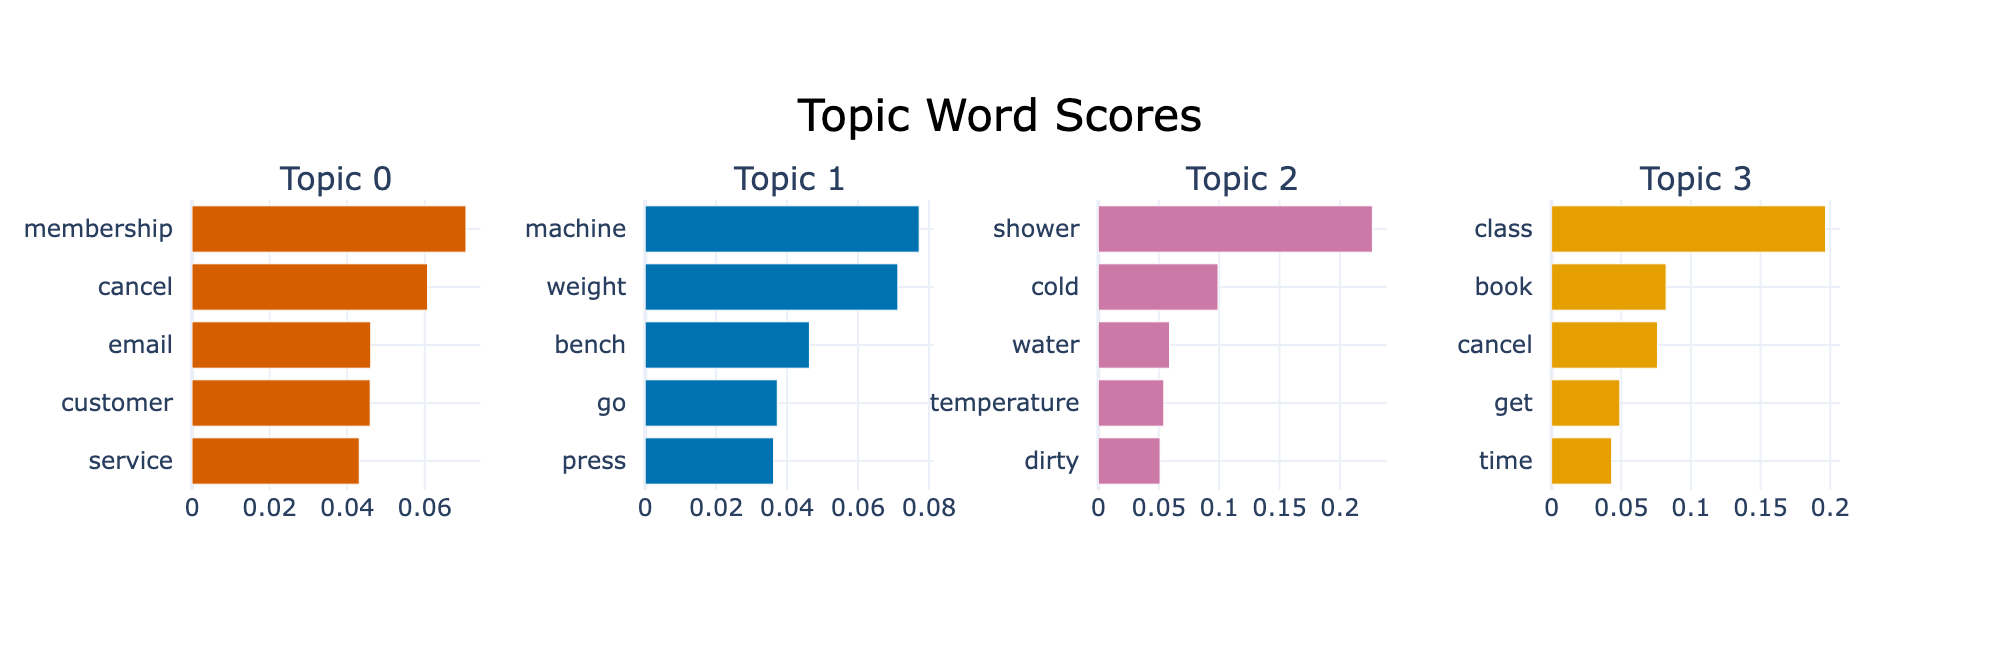


 bertopic_emotion_negative_sadness_heatmap_top4.png


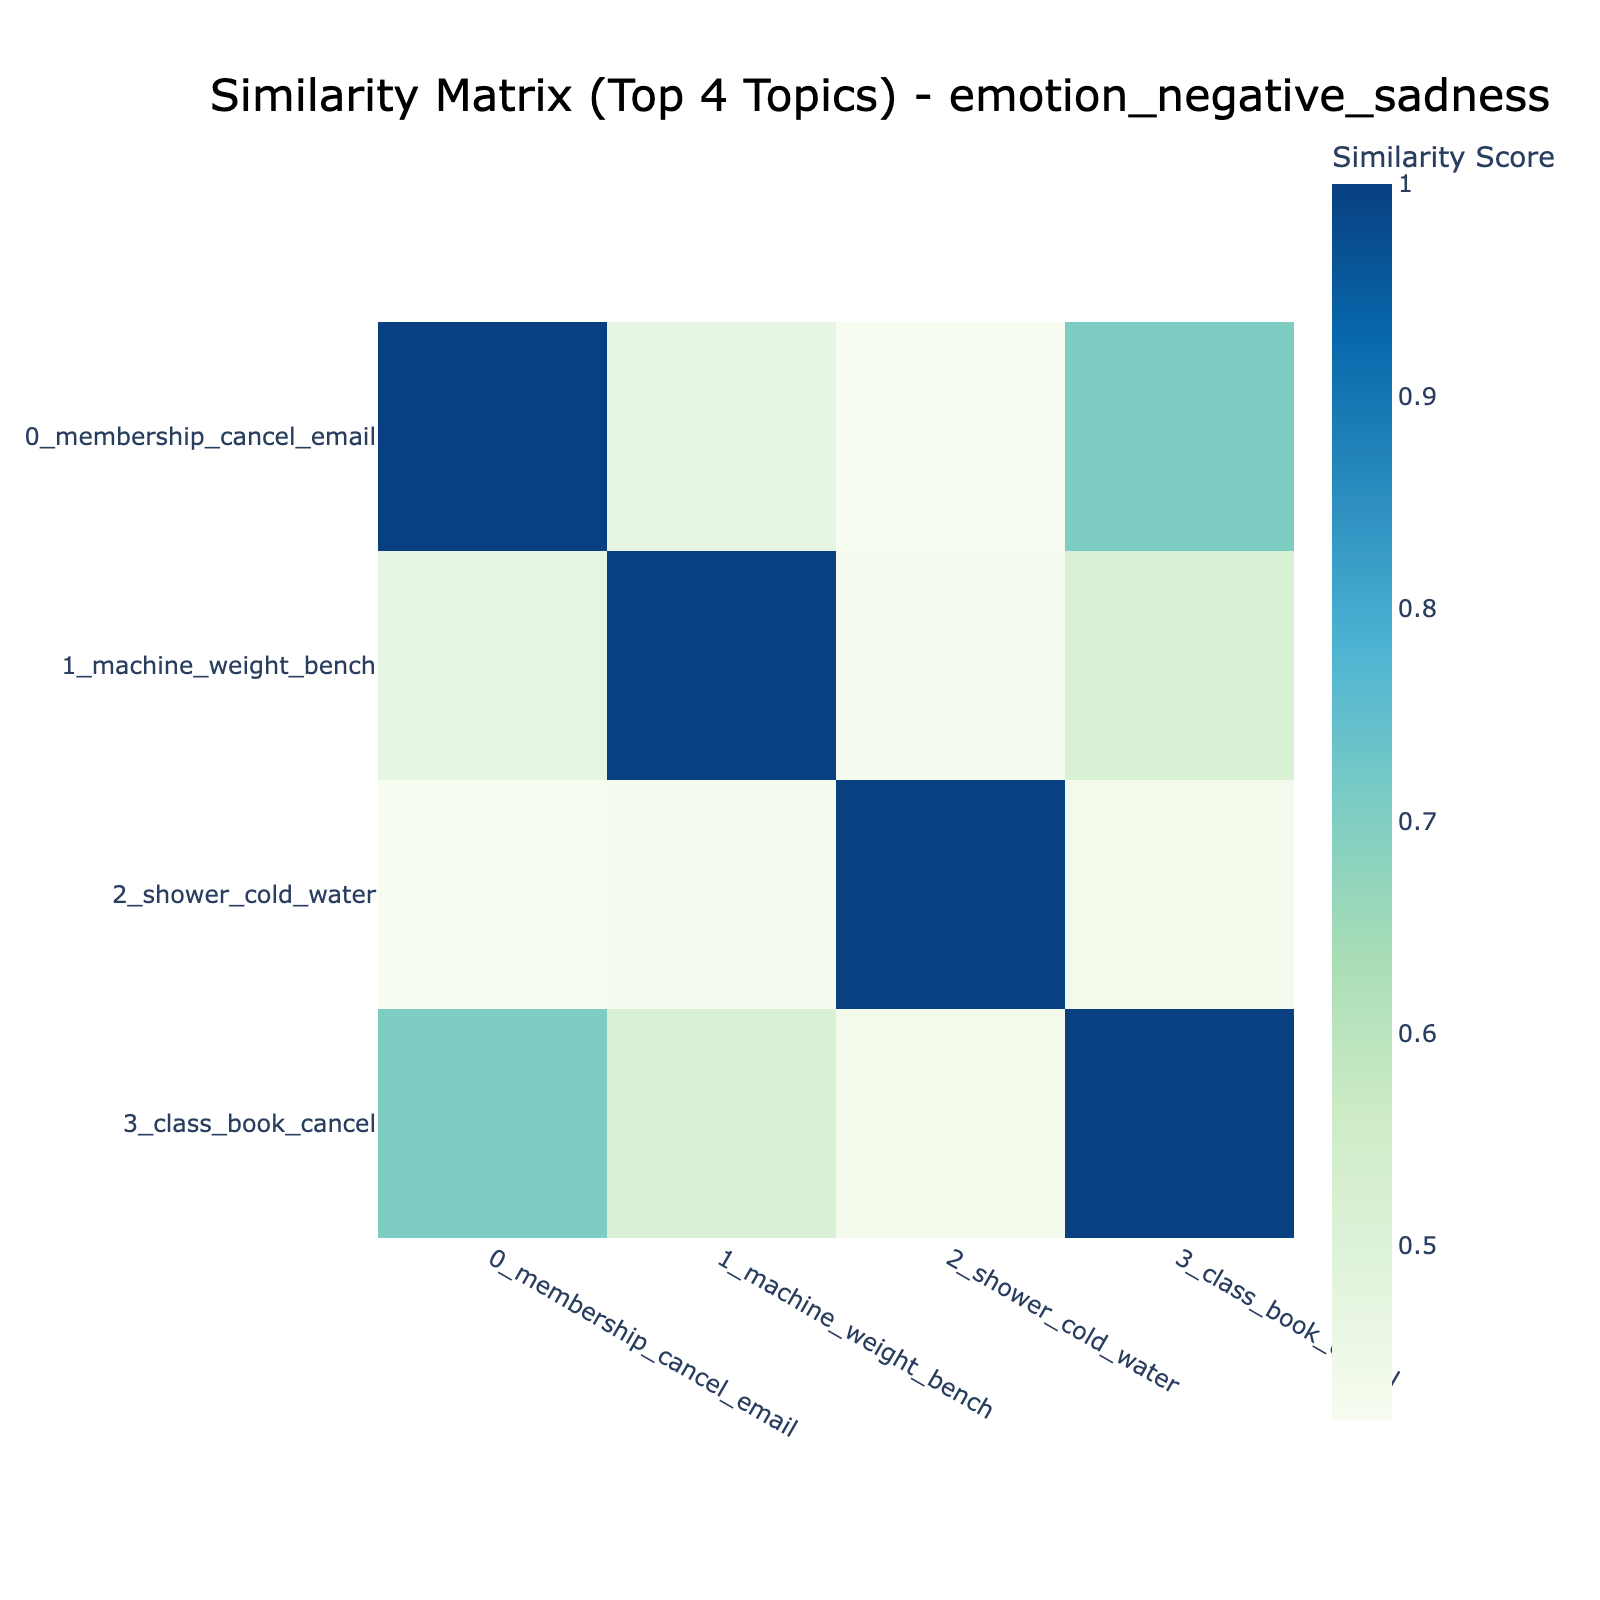


 bertopic_llm_topics_negative_barchart_top4.png


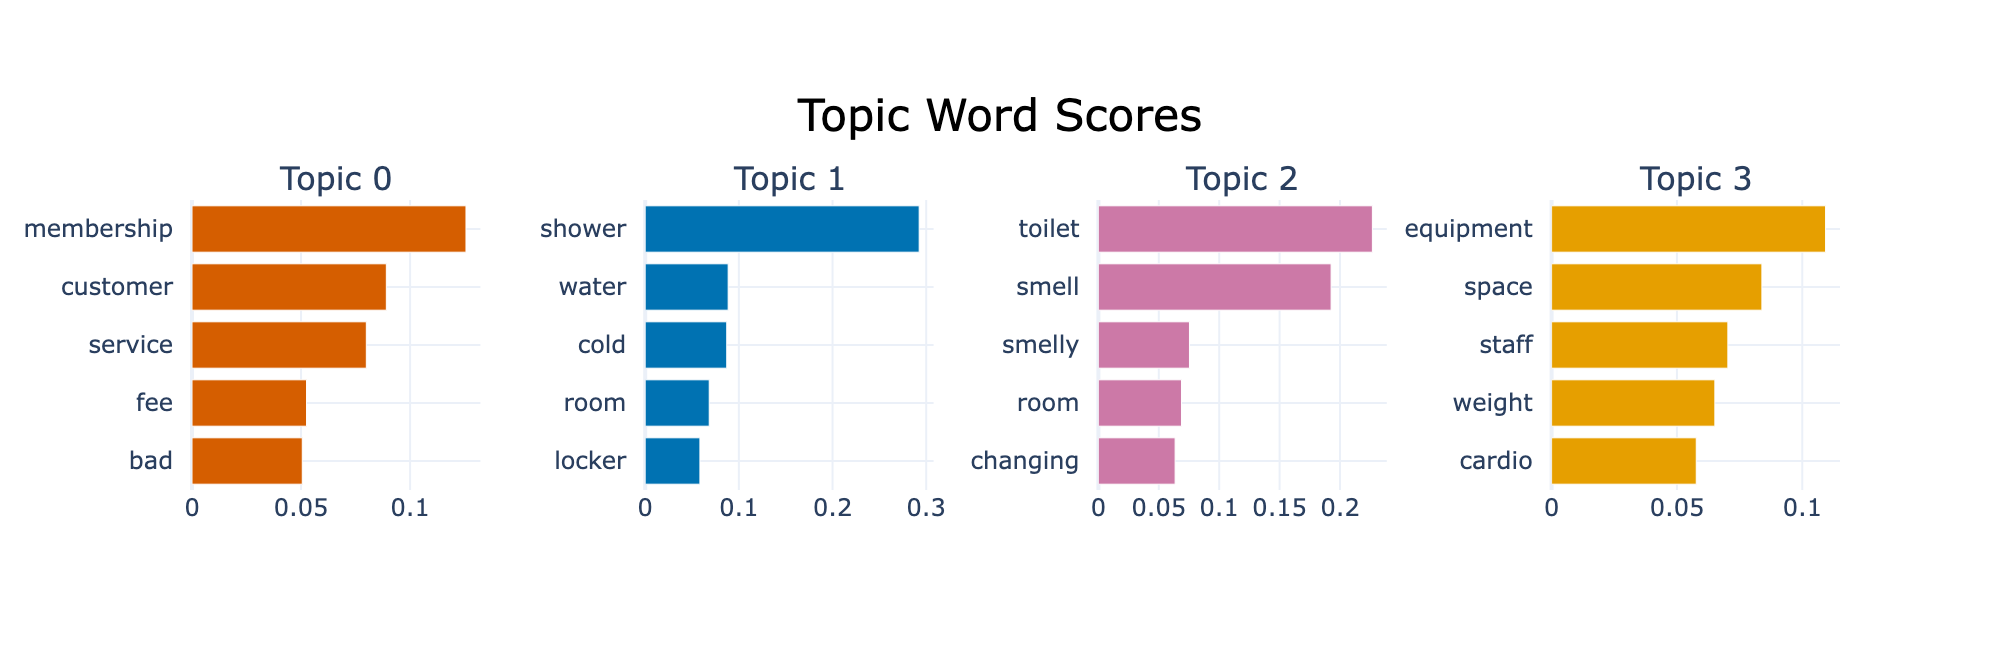


 bertopic_llm_topics_negative_heatmap_top4.png


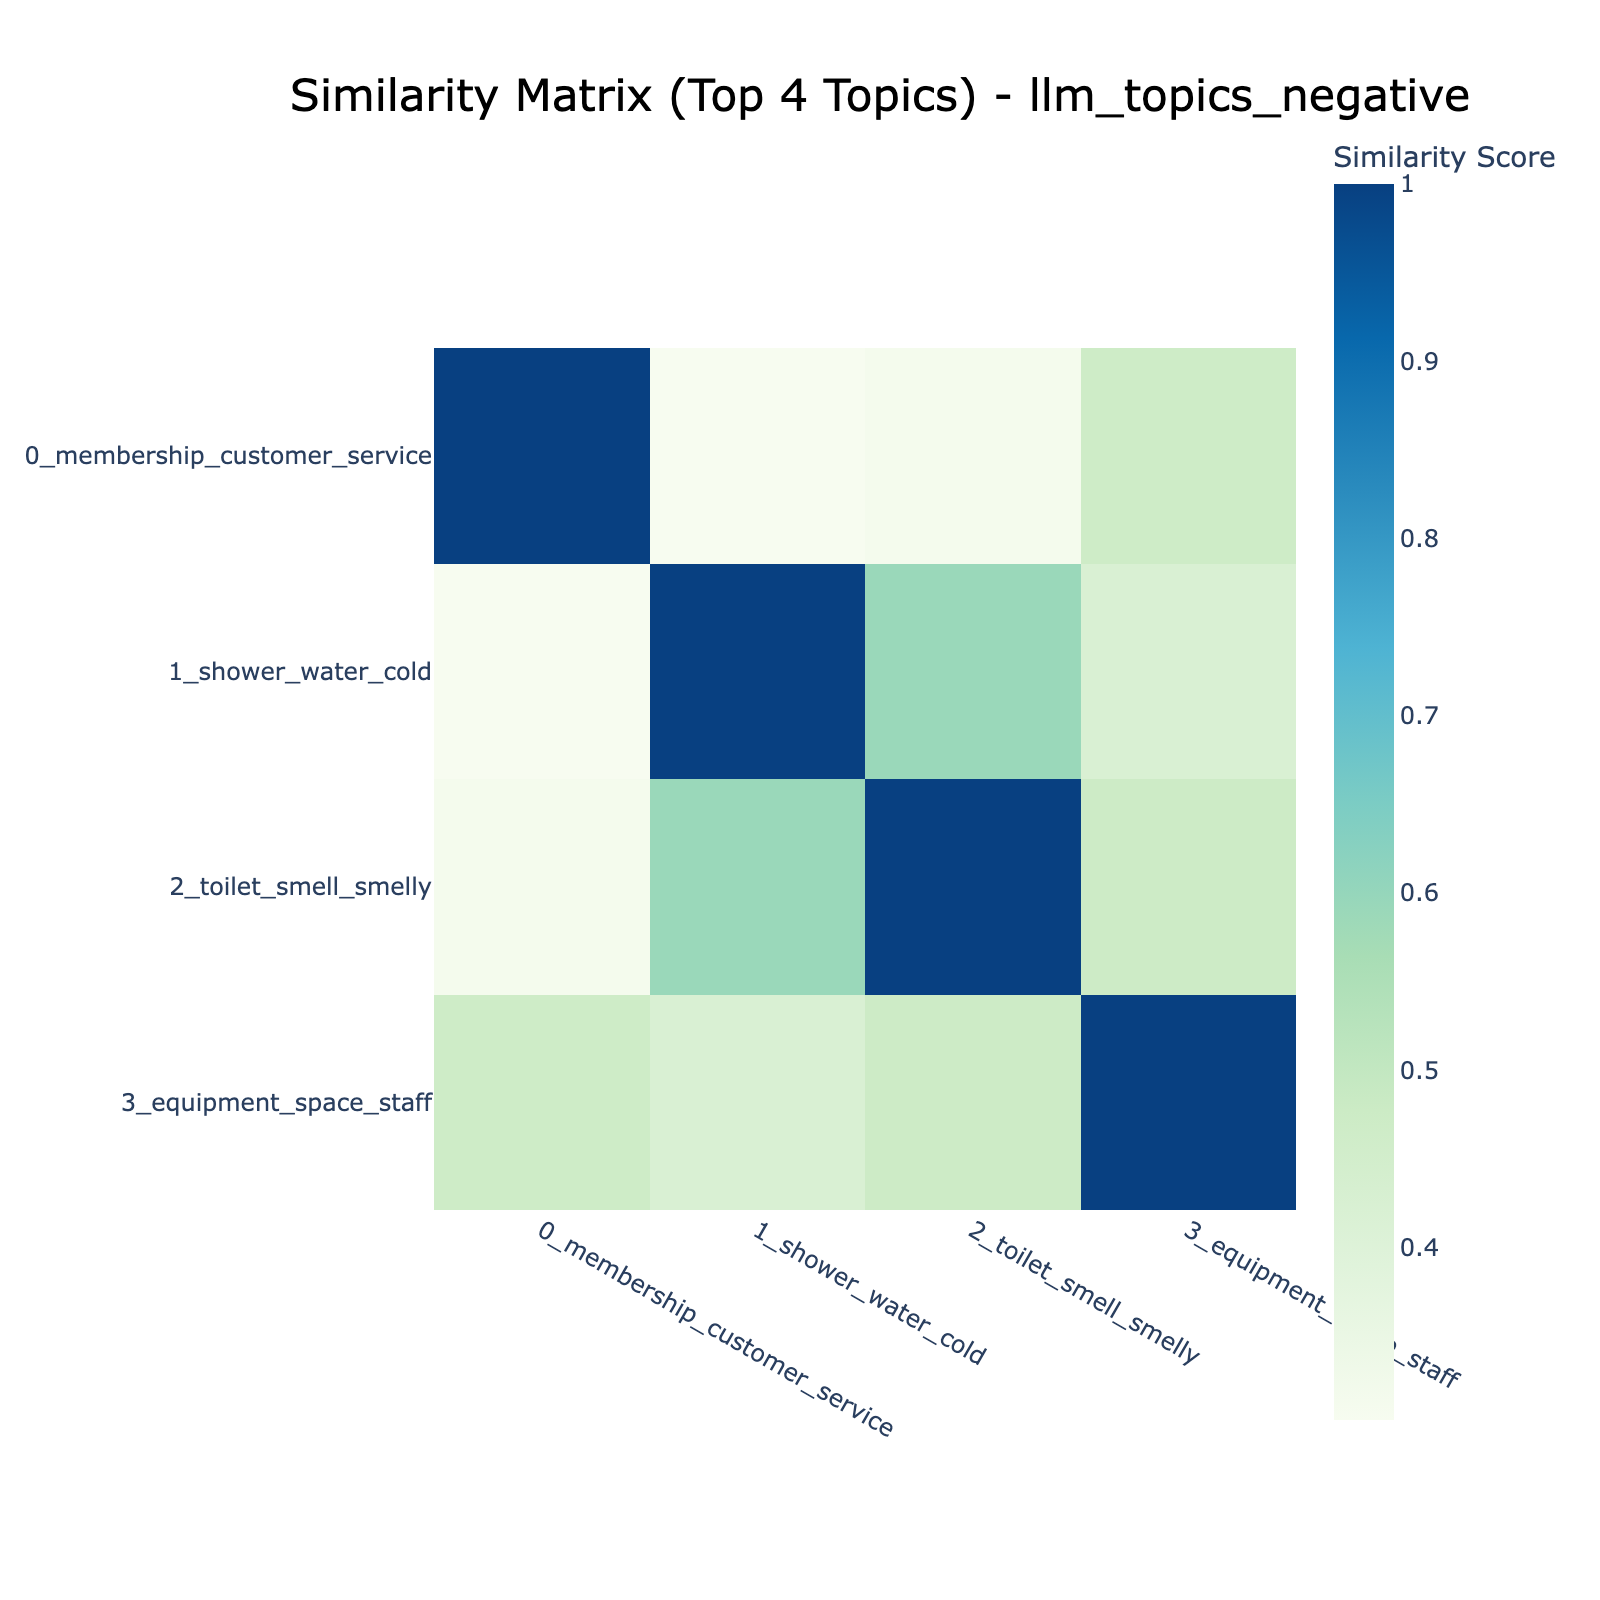


 bertopic_negative_barchart_top4.png


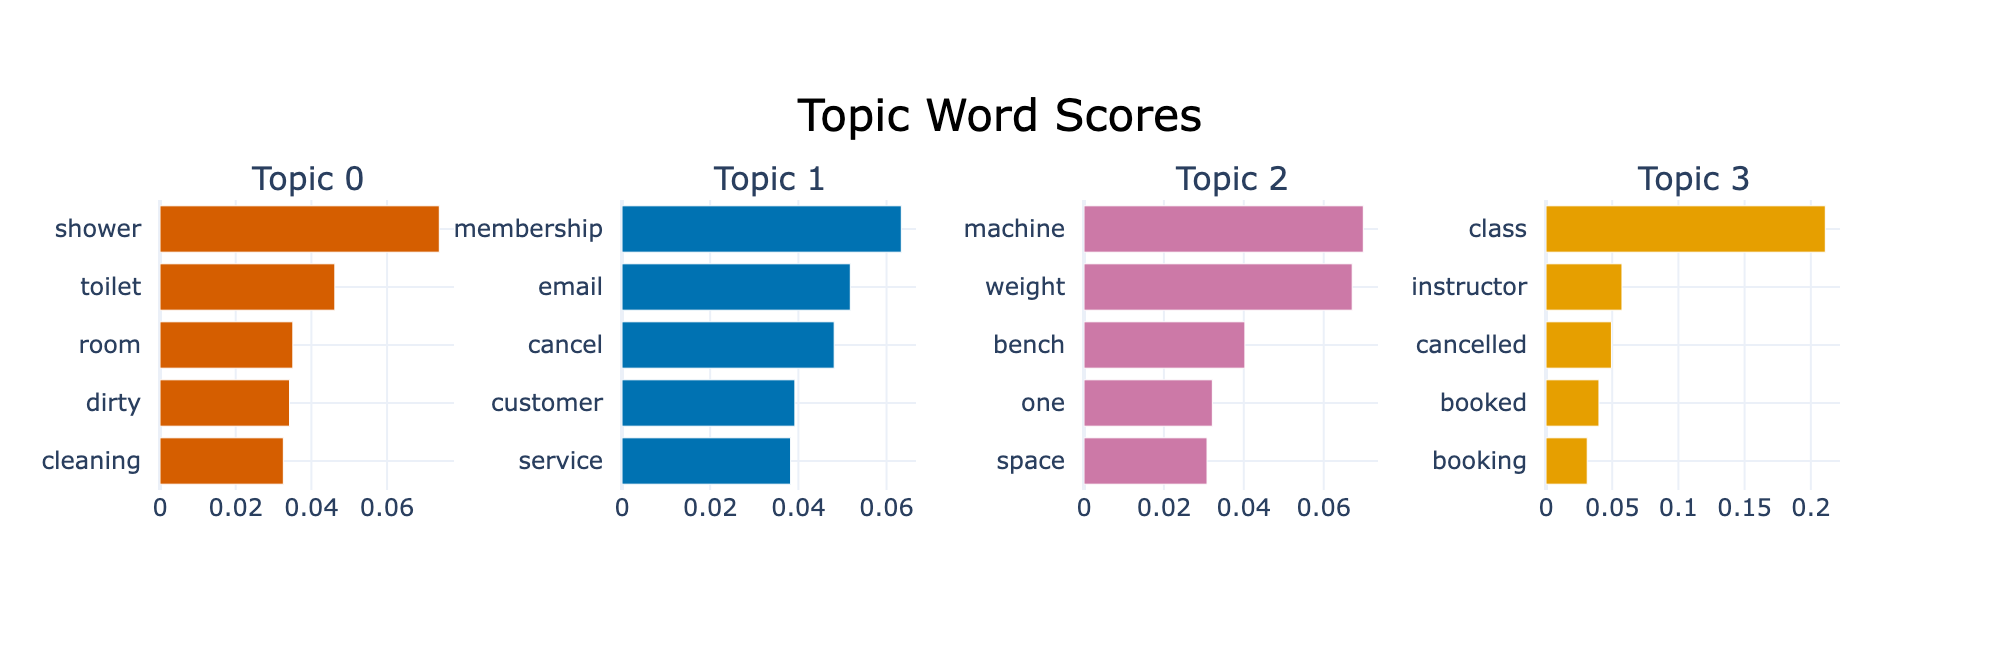


 bertopic_negative_heatmap_top4.png


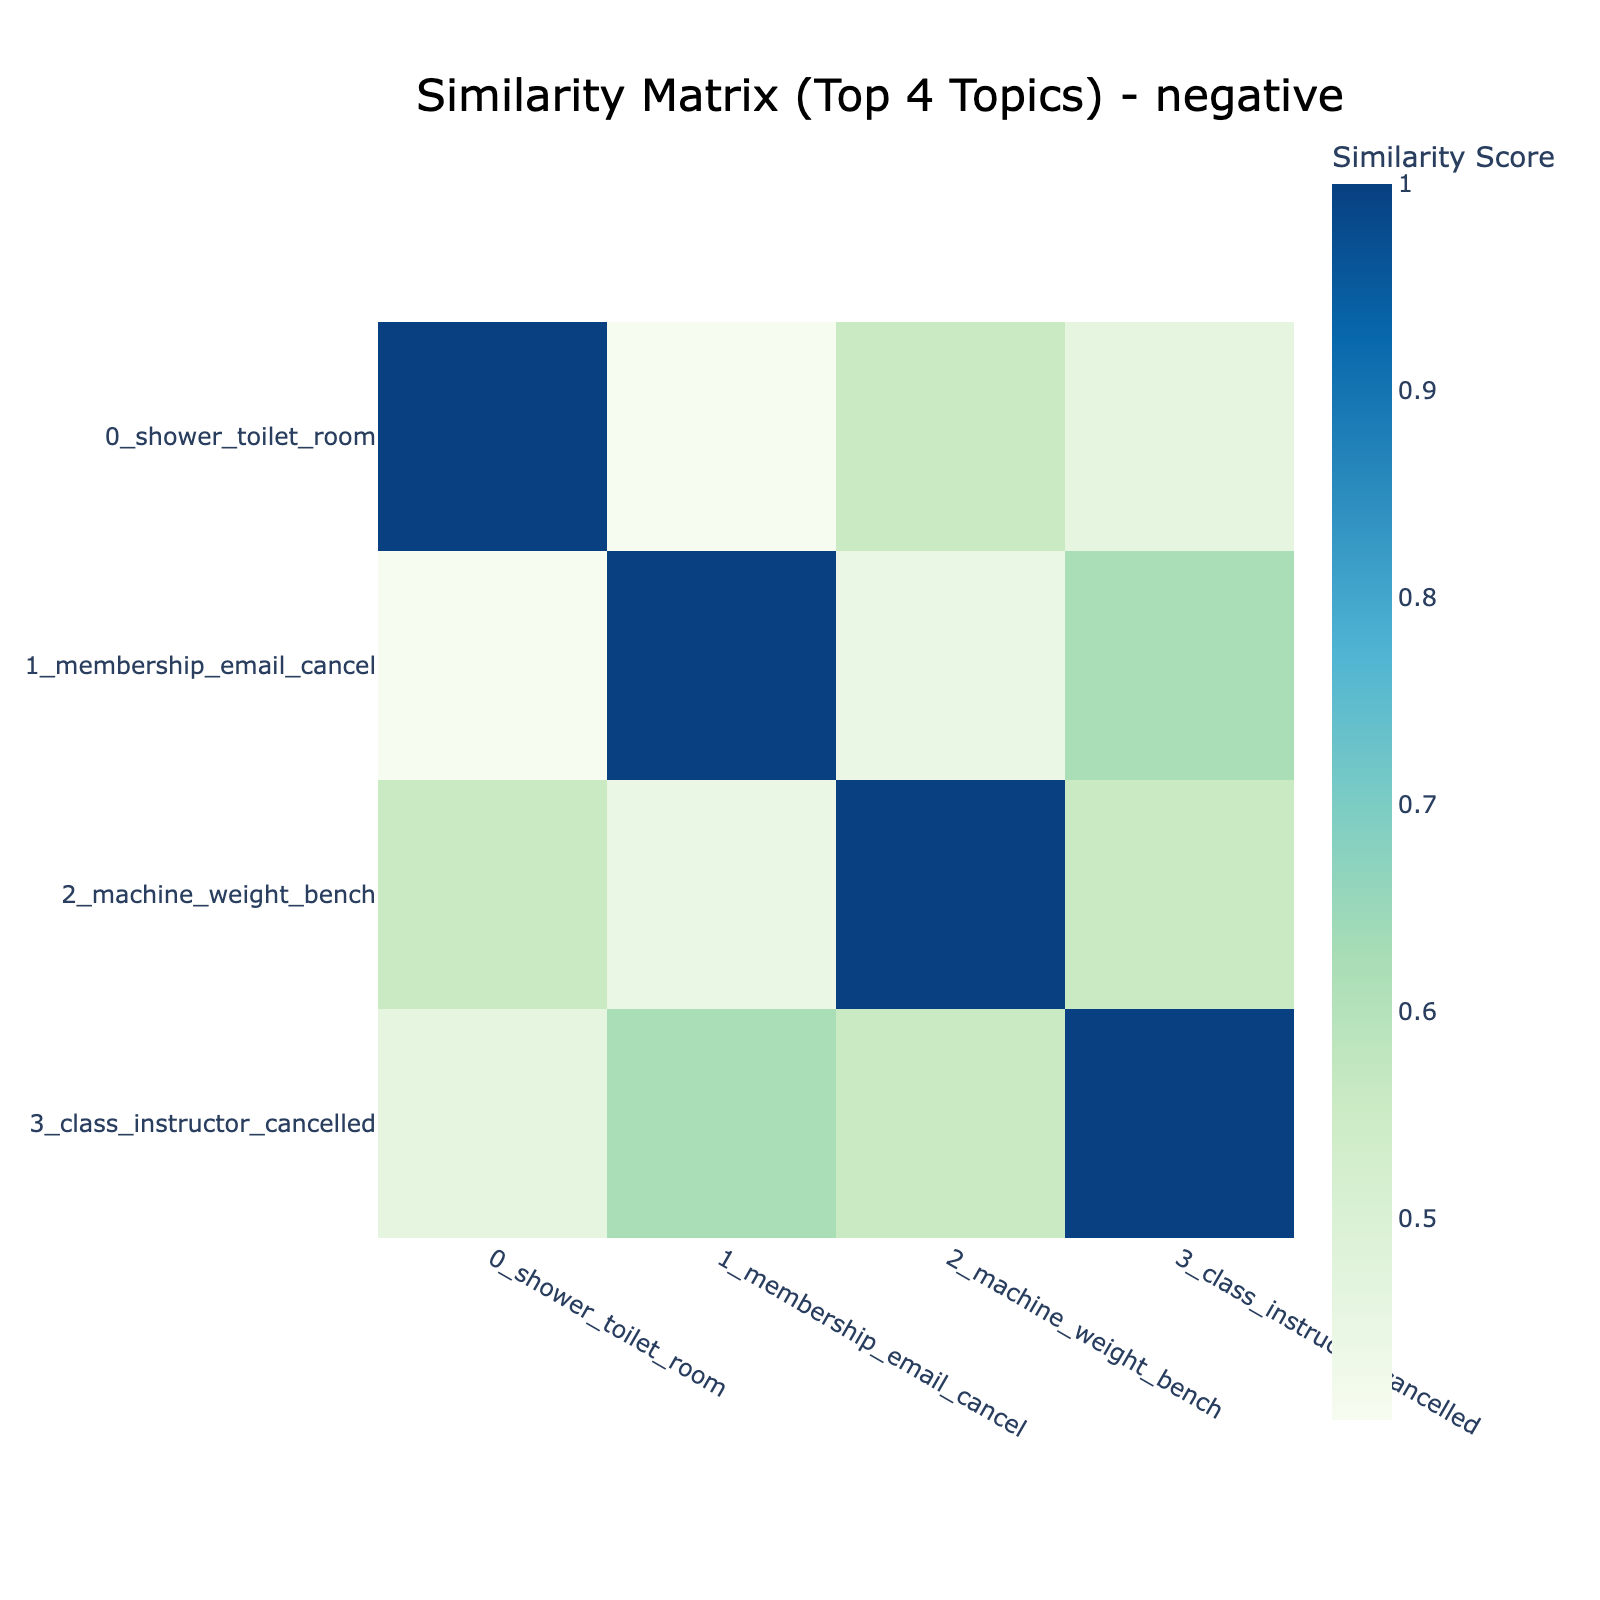


 bertopic_negative_intertopic_distance.png


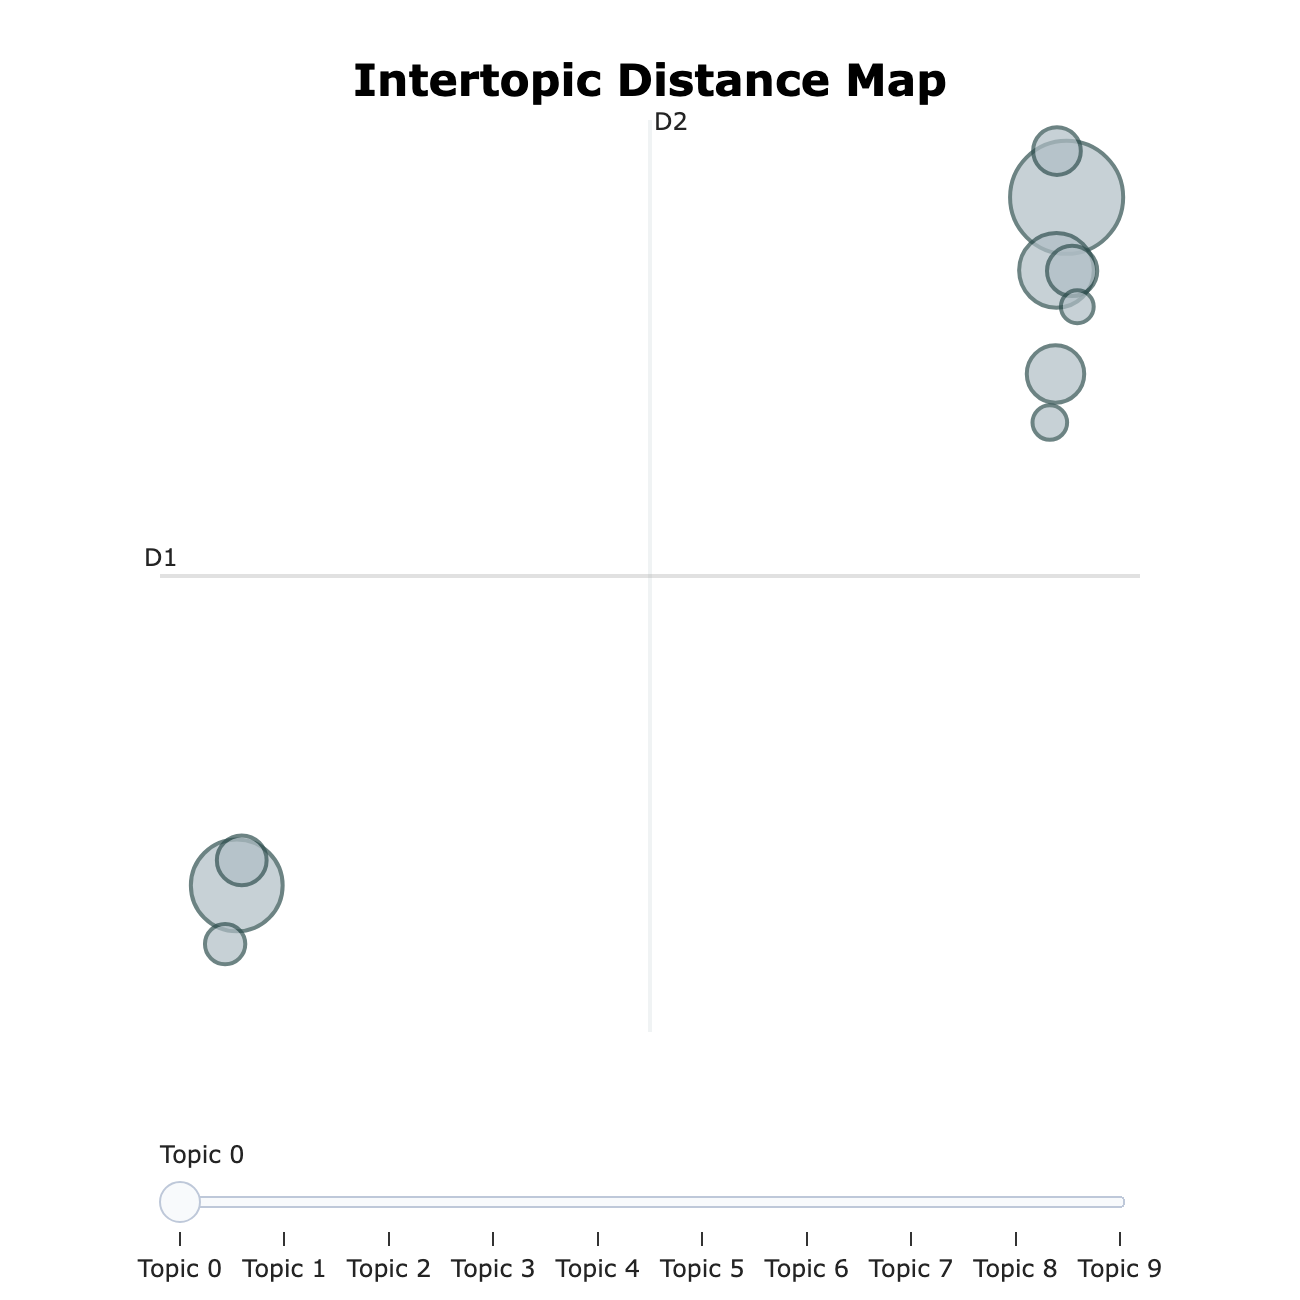


 emotion_distribution_negative_reviews_bhadresh_savani_bert_base_uncased_emotion.png


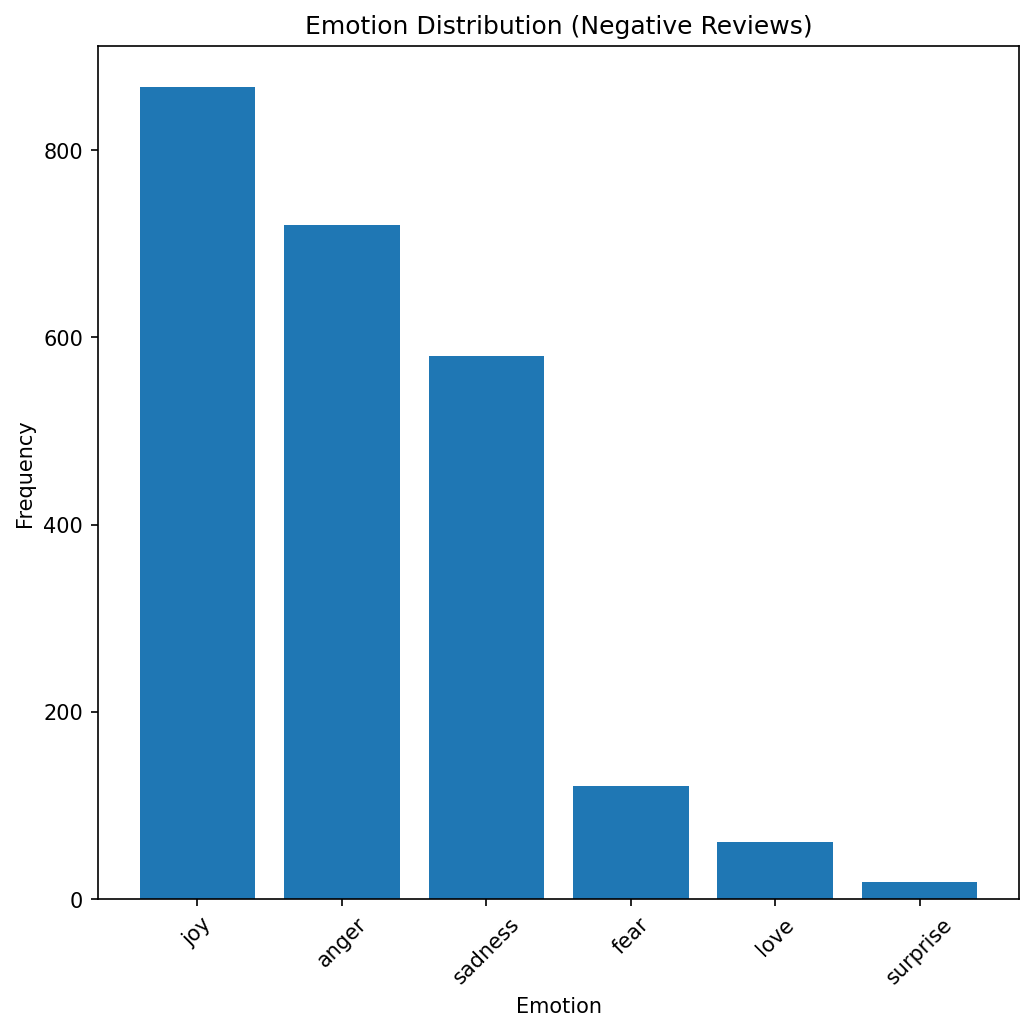


 emotion_distribution_negative_reviews_j_hartmann_emotion_english_distilroberta_base.png


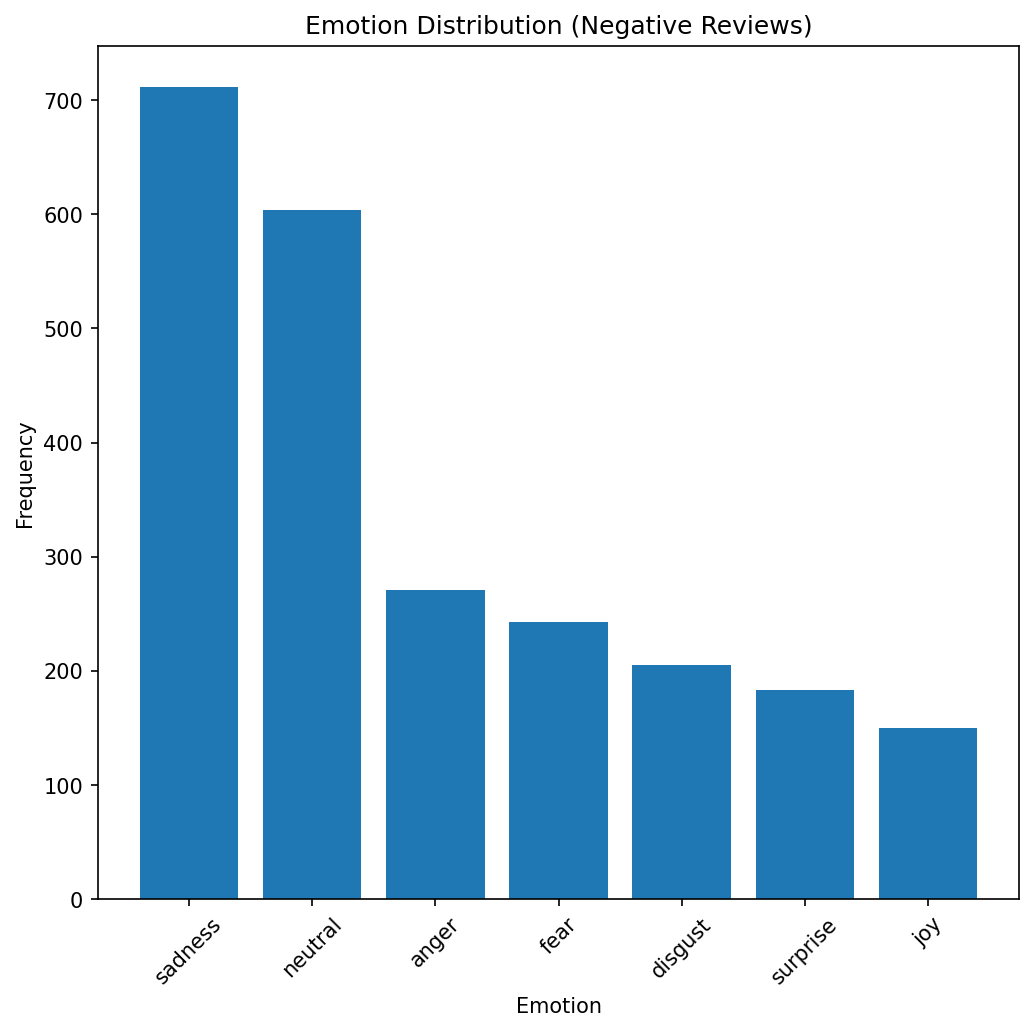


 trustpilot_negative_top10_words.png


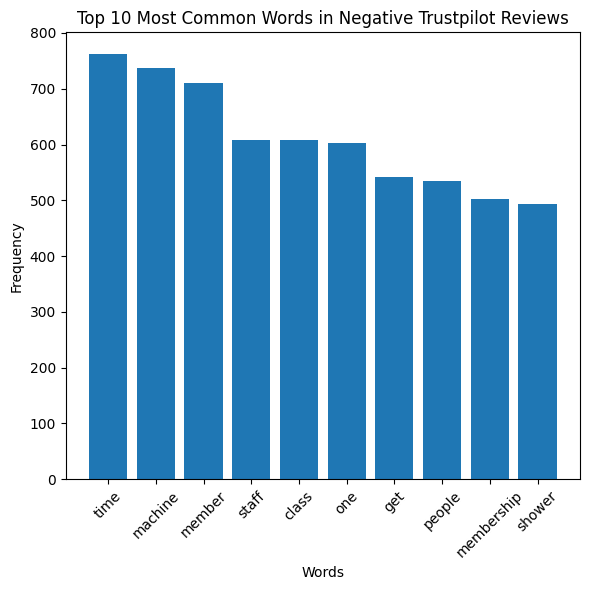


 trustpilot_non_negative_top10_words.png


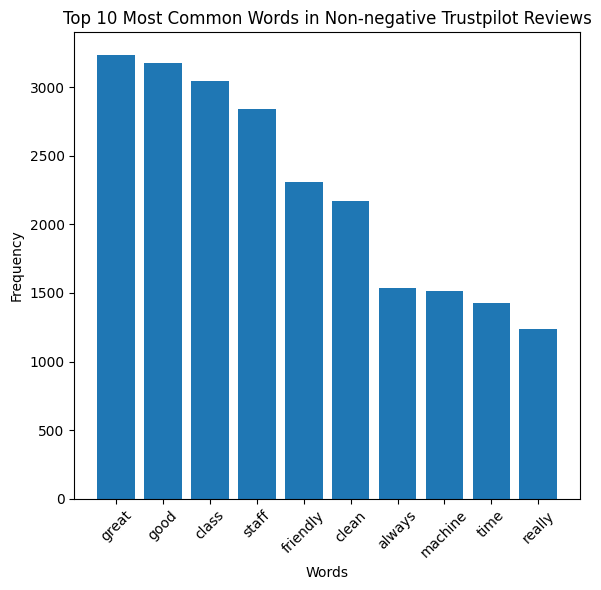


 trustpilot_top10_words.png


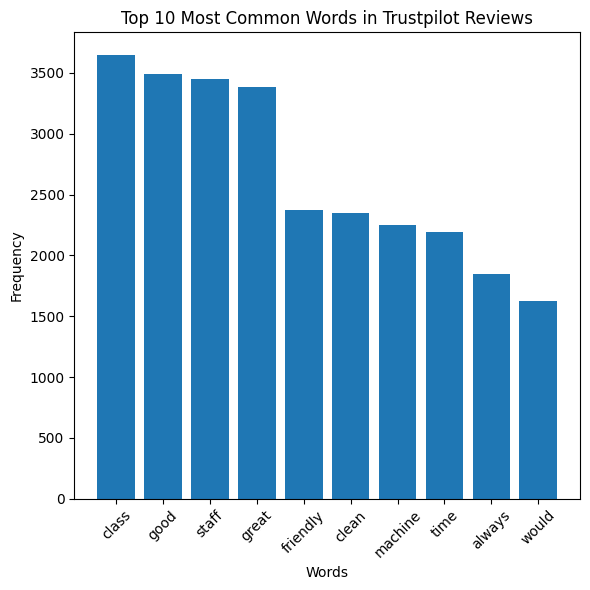

In [9]:
# Collect report PNG plots + display them in-notebook
REPORT_PLOTS_DIR = PROJECT_ROOT / "output/plots_report"
REPORT_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

TARGET_PNG_FILES = {
    "bertopic_negative_barchart_top4.png",
    "bertopic_emotion_negative_sadness_barchart_top4.png",
    "bertopic_negative_heatmap_top4.png",
    "bertopic_emotion_negative_sadness_heatmap_top4.png",
    "bertopic_negative_intertopic_distance.png",
    # "bertopic_emotion_negative_sadness_intertopic_distance.png",
    "bertopic_llm_topics_negative_barchart_top4.png",
    "bertopic_llm_topics_negative_heatmap_top4.png",
    # "bertopic_llm_topics_negative_intertopic_distance.png",
    "trustpilot_top10_words.png",
    "trustpilot_negative_top10_words.png",
    "trustpilot_non_negative_top10_words.png",
    "emotion_distribution_negative_reviews_j_hartmann_emotion_english_distilroberta_base.png",
    "emotion_distribution_negative_reviews_bhadresh_savani_bert_base_uncased_emotion.png",
}

all_pngs = [p for p in PLOT_DIR.rglob("*.png") if REPORT_PLOTS_DIR not in p.parents]
matches = {p.name: p for p in all_pngs if p.name in TARGET_PNG_FILES}

copied = []
for fname in sorted(TARGET_PNG_FILES):
    src = matches.get(fname)
    if src is None:
        continue
    dst = REPORT_PLOTS_DIR / fname  
    shutil.copy2(src, dst)
    copied.append(dst)

missing = sorted(TARGET_PNG_FILES - set(matches.keys()))
print("Report plots folder:", REPORT_PLOTS_DIR)
print(f"Copied {len(copied)} PNG file(s).")
if missing:
    print("Missing (not found anywhere under PLOT_DIR):")
    for m in missing:
        print("-", m)

# Display copied PNGs
for p in copied:
    print("\n", p.name)
    display(Image(filename=str(p)))
